In [1]:
%reset -f

In [2]:
import torch
import os
from pyDOE import lhs
from utils import torchIWT
import numpy as np
import scipy.io as sio
import torch.nn as nn
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 2947
# seed = 0
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
def get_burgers_data(Burgers_file):
    data = sio.loadmat(Burgers_file)
    x, t, usol = data['x'], data['t'], data['usol']
    print(x.shape, t.shape, usol.shape)
    X, T = np.meshgrid(x, t)
    x_test_np = np.concatenate((np.hstack(T.T).reshape(-1, 1), 
                                np.hstack(X.T).reshape(-1, 1)), 
                                axis=1)
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().reshape(-1, 1).to(device)
    return x, t, x_test, x_test_exact

In [5]:
def get_pinn_input_data(Nic, Nbc):
    x_init = torch.full([Nic, 1], -1) + torch.rand([Nic, 1]) * 2
    x_init_point = torch.cat((torch.zeros(Nic, 1), x_init), dim=1)
    x_init_label = -1 * torch.sin(np.pi * x_init_point[:, [1]])
    x_boundary_left_point = torch.cat((torch.rand([Nbc, 1]), torch.full([Nbc, 1], -1)), dim=1)
    x_boundary_right_point = torch.cat((torch.rand([Nbc, 1]), torch.ones([Nbc, 1])), dim=1)
    x_boundary_left_label = torch.zeros([Nbc, 1])
    x_boundary_right_label = torch.zeros([Nbc, 1])
    x_boundary_point = torch.cat((x_boundary_left_point, x_boundary_right_point), dim=0)
    x_boundary_label = torch.cat((x_boundary_left_label, x_boundary_right_label), dim=0)
    x_ic = x_init_point.to(device)
    u_ic = x_init_label.to(device)
    x_bc = x_boundary_point.to(device)
    u_bc = x_boundary_label.to(device)
    return x_ic, u_ic, x_bc, u_bc

In [6]:
def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = torch.autograd.Variable(x, requires_grad=True)
    u = train_U(x)
    d = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)  # d = [u_t, u_x]
    u_t = d[0][:, 0].unsqueeze(-1)
    u_x = d[0][:, 1].unsqueeze(-1)
    dd = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)  # dd = [u_xx]
    u_xx = dd[0][:, 1].unsqueeze(-1)
    f = u_t + u * u_x - (0.01 / np.pi) * u_xx
    return f

In [7]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)
    def forward(self, x):
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [8]:
class Model:
    def __init__(self, net, epoch,
                 lb, ub,
                 x_ic, u_ic, x_bc, u_bc,
                 x, t,
                 x_f_loss_fun,
                 x_test_point, x_test_exact):
        self.net = net
        self.epoch = epoch
        self.lb = lb
        self.ub = ub
        self.x_ic = x_ic
        self.u_ic = u_ic
        self.x_bc = x_bc
        self.u_bc = u_bc

        self.x = x
        self.t = t

        self.x_f_loss_fun = x_f_loss_fun
        self.x_test_point = x_test_point
        self.x_test_exact = x_test_exact

        self.sample_N = 2000
        self.sample_M = 1000

        self.x_f_N = None
        self.x_f_M = None

        self.x_ic_s = torch.tensor(0.).float().to(device)
        self.x_bc_s = torch.tensor(0.).float().to(device)
        self.x_f_s = torch.tensor(0.).float().to(device)

        self.x_test_estimate_collect = []

        self.top1 = torch.inf

    def true_loss(self, loss_e, loss_ic, loss_bc):
        loss = torch.exp(-self.x_f_s.detach()) * loss_e \
                + torch.exp(-self.x_ic_s.detach()) * loss_ic \
                + torch.exp(-self.x_bc_s.detach()) * loss_bc
        return loss
    
    def likelihood_loss(self, loss_e, loss_ic, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
                + torch.exp(-self.x_ic_s) * loss_ic.detach() + self.x_ic_s \
                + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss
    
    def evaluate(self):
        pred = self.net(self.x_test_point).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def random_sample(self, num):
        temp = torch.from_numpy(self.lb + (self.ub - self.lb) * lhs(2, num)).float().to(device)
        return temp

    def run(self, lr, wlr, j0, J_tmp, e_tmp):

        optim = torch.optim.Adam(self.net.parameters(), lr)
        optim_weight = torch.optim.Adam([self.x_f_s] + [self.x_ic_s] + [self.x_bc_s], lr=wlr)
        optim2 = torch.optim.LBFGS(self.net.parameters(), lr=1.0,
            max_iter=50000, max_eval=50000, history_size=50,
            tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        for i in range(self.epoch):
            u_ic_pred = self.net(self.x_ic)
            u_bc_pred = self.net(self.x_bc)
            x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
            f_pred = self.x_f_loss_fun(x_f, self.net)

            loss_e = torch.mean(f_pred ** 2)
            loss_ic = torch.mean((u_ic_pred - self.u_ic) ** 2)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)
            optim.zero_grad()

            loss = self.true_loss(loss_e, loss_ic, loss_bc)
            
            loss.backward()
            optim.step()
            if i % 2500 == 0:
                self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, loss: {}'.format(i, loss.item()), end='\r')
            
            optim_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_ic, loss_bc)
            loss.backward()
            optim_weight.step()
        print("\nOPTIM1 DONE")


        closure_i = 0
        def closure():
            optim2.zero_grad()
            u_ic_pred = self.net(self.x_ic)
            u_bc_pred = self.net(self.x_bc)
            x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
            f_pred = self.x_f_loss_fun(x_f, self.net)

            loss_e = torch.mean(f_pred ** 2)
            loss_ic = torch.mean((u_ic_pred - self.u_ic) ** 2)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)
            loss = self.true_loss(loss_e, loss_ic, loss_bc)

            loss.backward()
            nonlocal closure_i
            closure_i += 1

            print('network train epoch: {}, OPTIM2 LOSS:{}'.format(closure_i, loss.item()), end='\r')
            return loss
        
        optim2.step(closure)
        print("\nOPTIM2 DONE")
        error = self.evaluate()
        if error < self.top1:
            self.top1 = error
            torch.save(self.net.state_dict(), './best_model.pth')
        print('Test_L2error:', '{0:.2e}'.format(error))
        self.x_test_estimate_collect.append([error])
            
    def train(self, move_epoch, lr, wlr, j0, J, e):
        self.x_f_N = self.random_sample(self.sample_N)
        self.x_f_M = self.random_sample(self.sample_M)

        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_ic_s = torch.tensor(0.).float().to(device)
        self.x_bc_s = torch.tensor(0.).float().to(device)

        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_ic_s = nn.Parameter(self.x_ic_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)

        self.run(lr[0], wlr, j0, J, e)

        for j in range(1, move_epoch):
            print("epoch: ", j)
            if j > 4:
                lr_tmp = lr[-1]
            else:
                lr_tmp = lr[j]
            self.run(lr_tmp, wlr, j0, J, e) 
    
    def move_point(self, j0, J_tmp, e_tmp):
        imgl = self.net(self.x_test_point).reshape(self.x.shape[0], self.t.shape[0])
        iwt = torchIWT(j0, J_tmp, e_tmp).to(device)
        _, idxs = iwt.get_Iwt2d(imgl, self.x, self.t)
        idxn = []
        for i in idxs:
            idxn = idxn + i
        idxn = torch.tensor(idxn).to(device).float()
        print(idxn.shape)

        kde = gaussian_kde(idxn.cpu().T)
        expanded_idxns = kde.resample(self.sample_M).T
        expanded_idxns = torch.tensor(expanded_idxns).float().to(device)
        k = torch.cat((idxn, expanded_idxns), dim=0)

        k[:,0] = 2 * k[:, 0] / self.x.shape[0] - 1. 
        k[:,1] = k[:, 1] / self.t.shape[0]  
        k = k[(k[:, 0] >= self.lb[1]) & (k[:, 0] <= self.ub[1]) & (k[:, 1] >= self.lb[0]) & (k[:, 1] < self.ub[0])]
        k = torch.unique(k, dim=0)

        self.x_f_M = torch.zeros_like(k)
        self.x_f_M[:, 0] = k[:, 1]
        self.x_f_M[:, 1] = k[:, 0]
        
        print("\nnumber of moved point:{}".format(self.x_f_M.shape[0]))

In [9]:
Burgers_path = './burgers_shock.mat'
x, t, x_test_point, x_test_exact = get_burgers_data(Burgers_path)

(256, 1) (100, 1) (256, 100)


In [19]:
Nic = 200
Nbc = 200
x_ic, u_ic, x_bc, u_bc = get_pinn_input_data(Nic, Nbc)

In [11]:
layers = [2, 20, 20, 20, 20, 1]
epoch = 5000

lb = np.array([0.0, -1.0])
ub = np.array([1.0, 1.0])
net = Net(layers).to(device)

model = Model(net, epoch,
                lb, ub,
                x_ic, u_ic, x_bc, u_bc,
                x, t,
                x_f_loss_fun,
                x_test_point, x_test_exact)

lr = [0.001, 0.001, 0.0003, 0.0001, 0.00003]
wlr = 0.001

j0 = 0
J = 5
e = 0.03

model.train(move_epoch=10, lr=lr, wlr=wlr, j0=j0, J=J, e=e)


number of moved point:366
network train epoch: 2499, loss: 0.15942002832889557
number of moved point:917
network train epoch: 4999, loss: 0.72860205173492436
OPTIM1 DONE
network train epoch: 7049, OPTIM2 LOSS:0.0006772752967663109
OPTIM2 DONE
Test_L2error: 1.50e-03
epoch:  1

number of moved point:967
network train epoch: 2499, loss: 0.5059861540794373544
number of moved point:977
network train epoch: 4999, loss: 0.026394871994853025
OPTIM1 DONE
network train epoch: 1053, OPTIM2 LOSS:0.0075569348409771926
OPTIM2 DONE
Test_L2error: 1.35e-03
epoch:  2

number of moved point:966
network train epoch: 2499, loss: 0.556492090225219765
number of moved point:954
network train epoch: 4999, loss: 0.19151891767978668
OPTIM1 DONE
network train epoch: 16, OPTIM2 LOSS:0.17591798305511475
OPTIM2 DONE
Test_L2error: 1.94e-03
epoch:  3

number of moved point:972
network train epoch: 2499, loss: 1.97724628448486337
number of moved point:966
network train epoch: 4999, loss: 1.0433205366134644
OPTIM1 DONE

In [12]:
x_test_pred = net(x_test_point)

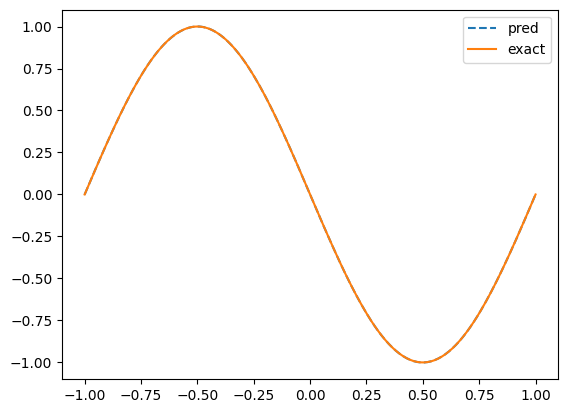

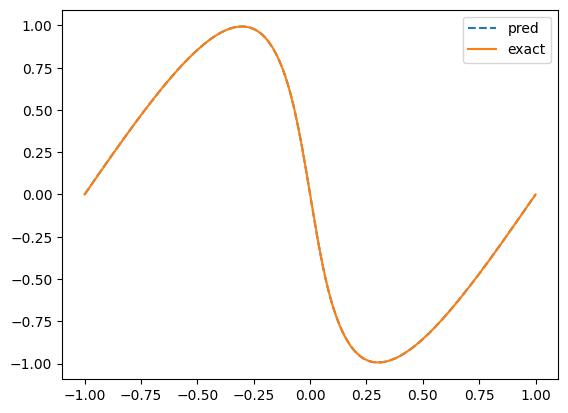

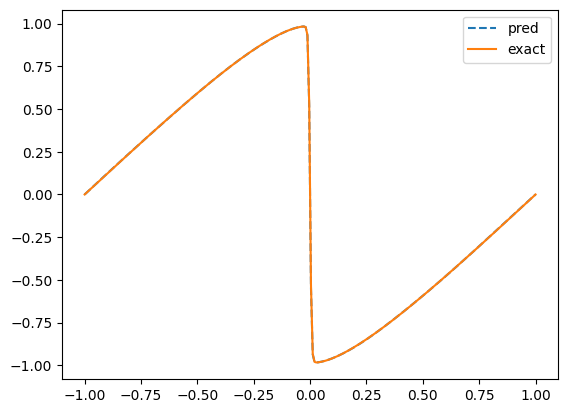

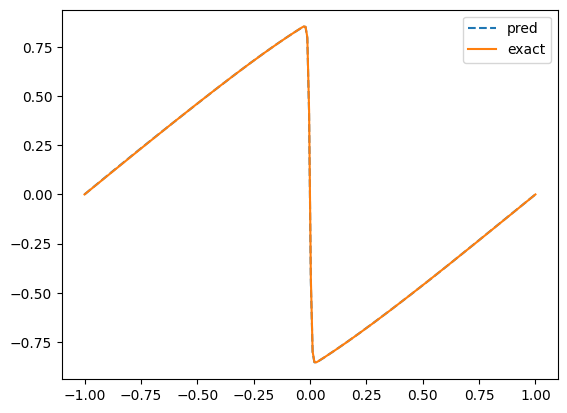

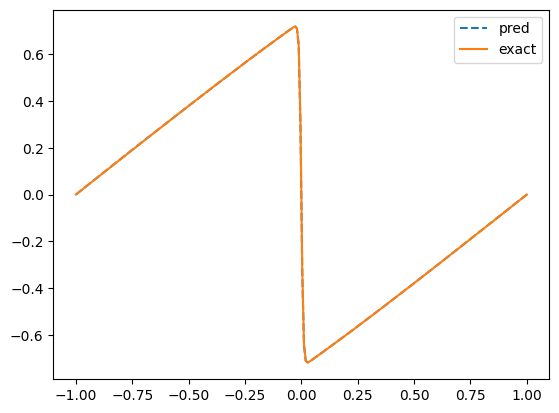

In [13]:
x_test_pred = net(x_test_point)
x_test_pred = x_test_pred.reshape(x.shape[0], t.shape[0])
x_test_pred = x_test_pred.to('cpu').detach().numpy()
x_test_exact = x_test_exact.reshape(x.shape[0], t.shape[0])
x_test_exact = x_test_exact.to('cpu').detach().numpy()
x = x.to('cpu').detach().numpy()
t = t.to('cpu').detach().numpy()
plt.figure()
plt.plot(x, x_test_pred[:, 0], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 0], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 20], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 20], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 50], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 50], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 75], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 75], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 99], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 99], label='exact')
plt.legend()

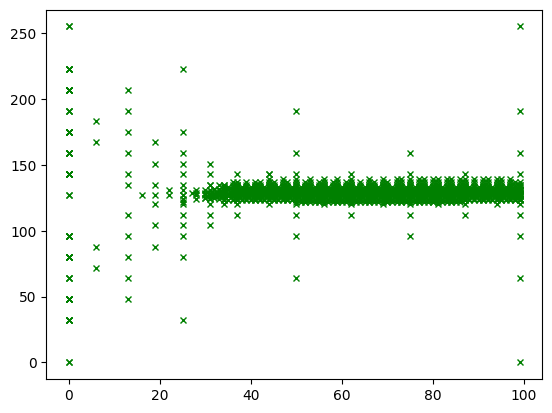

In [14]:
imgl = model.net(model.x_test_point).reshape(model.x.shape[0], model.t.shape[0])

iwt = torchIWT(j0, 7, 0.03).to(device)

_, idxs = iwt.get_Iwt2d(imgl, model.x, model.t)
idxn = []
for i in idxs:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()
plt.plot(idxn[:, [1]].cpu().numpy(), idxn[:, [0]].cpu().numpy(), 'gx', markersize=4)